# pvanalysis

The `pvanalysis` package of `SLAM` is a tool to identify Keplerian disks in protostellar systems using position-velocity (PV) diagrams and estimate the dynamical mass of protostars if disks are present. This tool basically consists of two steps: `get_edgeridge`, which determines edge/ridge points that trace rotation curve features of PV diagrams, and `fit_edgeridge`, which performs the power-law fitting with the obtained edge/ridge points. In this note, we will briefly present how to use this tool.

In [3]:
import numpy as np
# if you need to set a path
import sys
sys.path.append('D:\L1489_IRS_ssp\SLAM') # add PATH to SLAM

from pvanalysis import PVAnalysis
import matplotlib.pyplot as plt

In [4]:
#%matplotlib widget

## Basic usage B6

Here is an example only with the most basic input parameters to deomnstrate the simplest usage. The first step of `pvanalysis` is to extract edge/ridge points from a PV diagram.

In [5]:
# -------- INPUTS --------
fitsfile = "testfits/L1489irs_model_i_73.0with_beam_conv_upd_hdr_0.01as_pv.fits"
outname = "pvanalysis_b6_gridge"  # file name header for outputs
incl = 73.  # inclunation angle (deg)
vsys = 7.37  # systemic velocity (km/s)
dist = 140.  # distance to the object (pc)
rms = 6.92e-12  # rms noise level (Jy/beam)
thr = 5.  # threshold for noise cut-off for edge/ridge calculations (rms)
# -------------------------


# read PV diagram
# give rms, vsys, distance, and inclination angle
impv = PVAnalysis(fitsfile, rms, vsys, dist, incl=incl, pa=0.)
# get edge/ridge points
impv.get_edgeridge(outname, thr=thr, xlim=[-1000.,0,0,1000.], ridgemode='gauss', pixrng_vcut=3)
impv.write_edgeridge(outname=outname)

read_pvfits: Input P.A.: 0.0 deg
read_pvfits: Convert frequency to velocity
Along position axis.
x range: -8.00 -- 8.00 arcsec
v range: 2.37 -- 12.37 km/s
Along velocity axis.
x range: -8.00 -- 8.00 arcsec
v range: 2.37 -- 12.37 km/s
Derived points in pvanalysis_b6_gridge.edge.dat and pvanalysis_b6_gridge.ridge.dat.


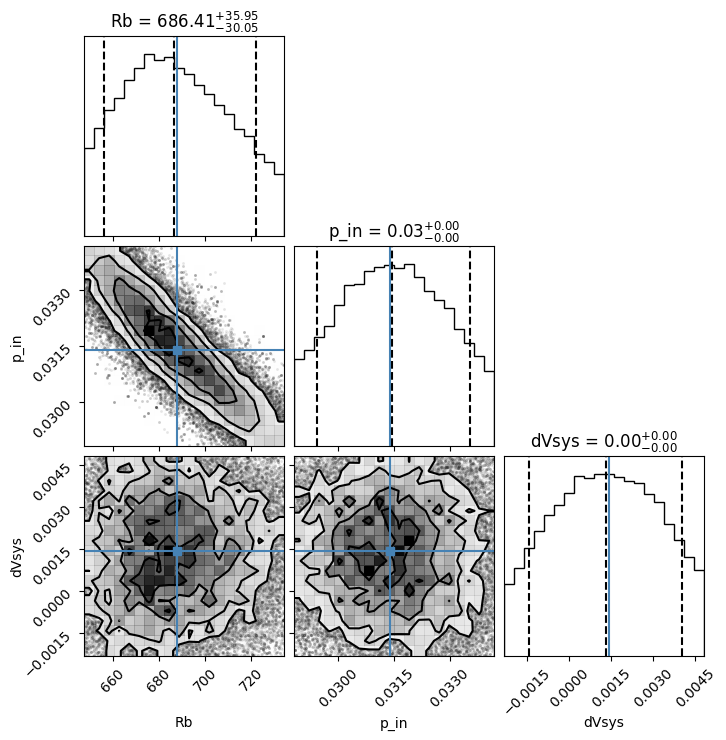

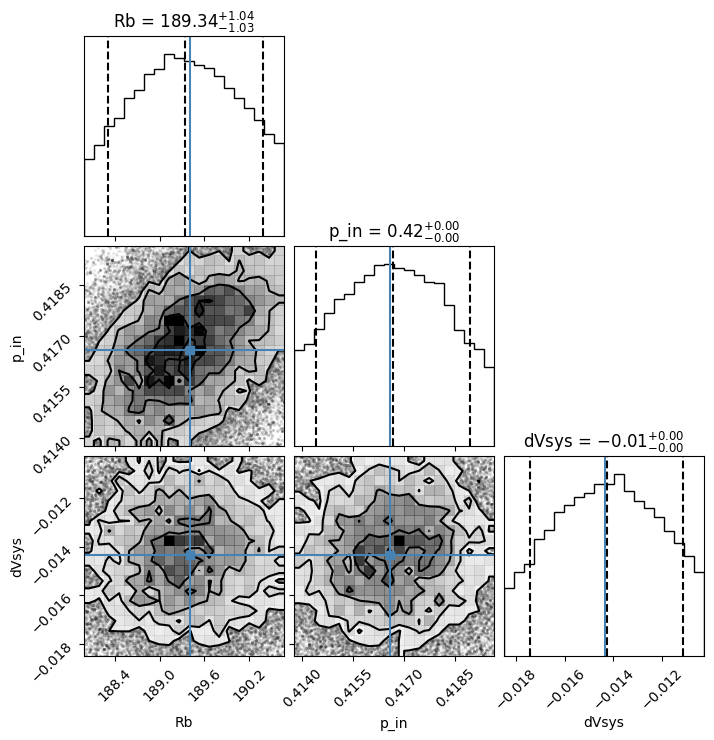

Corner plots in pvanalysis_b6_gridge.corner_e.png and pvanalysis_b6_gridge.corner_r.png
--- Edge ---
R_b   = 686.41 +/- 33.00 au
!!! Rb is NOT a break (disk) radius in the single-power fitting. !!!
V_b   = 4.884 +/- 0.000 km/s
!!! Vb is a middle velocity in the single-power fitting. !!!
p_in  = 0.031 +/- 0.002
dp    = 0.000 +/- 0.000
v_sys = 7.371 +/- 0.003
r     = 319.65 --- 1119.69 au
v     = 4.811 --- 5.005 km/s
M_in  = 9.863 +/- 0.705 Msun
M_out = 31.928 +/- 0.122 Msun
M_b   = 20.185 +/- 0.971 Msun
--- Ridge ---
R_b   = 189.34 +/- 1.04 au
!!! Rb is NOT a break (disk) radius in the single-power fitting. !!!
V_b   = 2.342 +/- 0.000 km/s
!!! Vb is a middle velocity in the single-power fitting. !!!
p_in  = 0.417 +/- 0.002
dp    = 0.000 +/- 0.000
v_sys = 7.356 +/- 0.003
r     = 30.40 --- 1035.92 au
v     = 1.139 --- 5.005 km/s
M_in  = 0.944 +/- 0.011 Msun
M_out = 1.699 +/- 0.018 Msun
M_b   = 1.280 +/- 0.007 Msun


In [6]:
# power law fitting
# --------- input parameters ----------
include_vsys = True  # vsys offset. False means vsys=0.
include_dp = False  # False means a single power
include_pin = True # False means pin=0.5 (Keplerian).
fixed_pin = 0.5  # Set the fixed pin value when include_pin is False.
fixed_dp = 0.0  # Set the fixed dp value when include_dp is False.
show_corner = True # if show corner plots or not
# -------------------------------------
impv.fit_edgeridge(include_vsys=include_vsys,
                   include_dp=include_dp,
                   include_pin=include_pin,
                   fixed_pin=fixed_pin, fixed_dp=fixed_dp,
                   outname=outname, rangelevel=0.8,
                   show_corner=show_corner)
impv.output_fitresult()


In [7]:
# For ridge

V_b, V_b_err = 2.342, 0.000
R_b, R_b_err = 189.34 , 1.04
V_sys, V_sys_err = 7.356, 0.003
p = 0.417 
perr = 0.002



# Find scaling constant V100 (V at r = 100) using Vb, Rb... equate V_b(r/Rb)**-0.5 with V_100(r/100)**-0.5 

V_100 = V_b*np.power(R_b/100, p)

# Calculate the partial derivatives
dv_dvb = (100 / R_b)**p
dv_drb = -V_b * p * (100 / R_b)**p * (1 / R_b)
dv_dp = V_b * (100 / R_b)**p * np.log(100 / R_b)

# Calculate the propagated error using the partial derivatives
sigma_v = np.sqrt((dv_dvb * V_b_err)**2 + (dv_drb * R_b_err)**2 + (dv_dp * perr)**2)


print(round(V_100,3))
print(round(sigma_v,3))

3.056
0.005


The input parameters set free parameters and which model function (single or double power-law) is adopted. In the above case, the fitting model is a double-power law function with a fixed inner power-law index ($p_\mathrm{in}=0.5$). The fitting searches the best break point ($R_\mathrm{b}$, $V_\mathrm{b}$), where the power-law index changes, and $dp$, which is deviation of the outer power-law index from the innder one. The dynamical mass ($M_\mathrm{b}$) is estimated from the set of ($R_\mathrm{b}$, $V_\mathrm{b}$) and a given inclination angle assuming a Keplerian rotation.

The edge/ridge points and the best-fit functions can be visualized as follows.

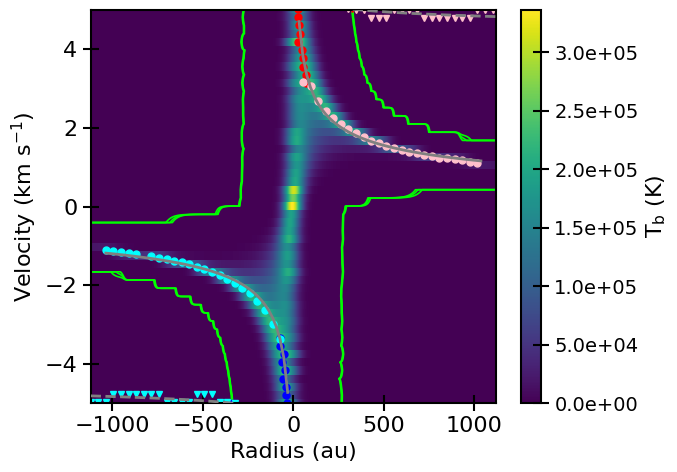

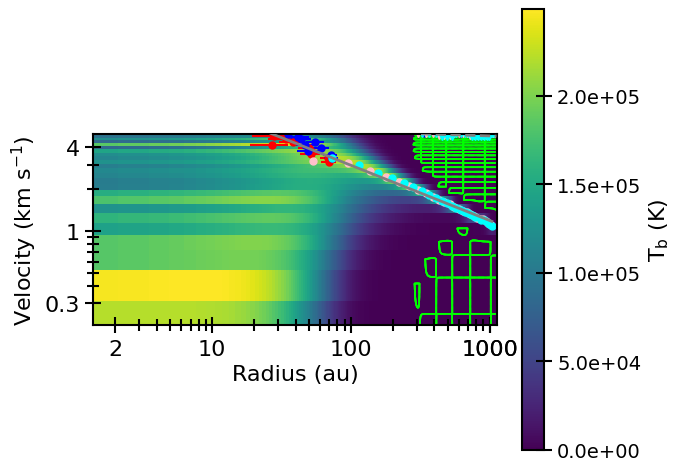

In [18]:
# plot results
impv.plot_fitresult(outname=outname, clevels=[-3,3,6,9],
                    vlim=[1.e-10,15.],
                    Tbcolor=True,
                    kwargs_pcolormesh={'cmap':'viridis'},
                    kwargs_contour={'colors':'lime'},                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
                    fmt={'edge':'v', 'ridge':'o'},
                    linestyle={'edge':'--', 'ridge':'-'})